In [135]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

import googlemaps
import json
import pickle
import re
import gzip

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
sns.set(style='whitegrid', context='notebook')

import datetime

#models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

#natural lanuage processing related
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#visualization
import shapely
import geopandas as gpd
import os
import folium

pd.options.mode.chained_assignment = None 

## loading dataset

In [141]:
airbnb_capetown_raw = pd.read_csv('../airbnb_capetown/listings.csv.gz')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
airbnb_capetown_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23368 entries, 0 to 23367
Columns: 106 entries, id to reviews_per_month
dtypes: float64(26), int64(21), object(59)
memory usage: 18.9+ MB


In [4]:
for col in airbnb_capetown_raw.columns:
    print(col)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

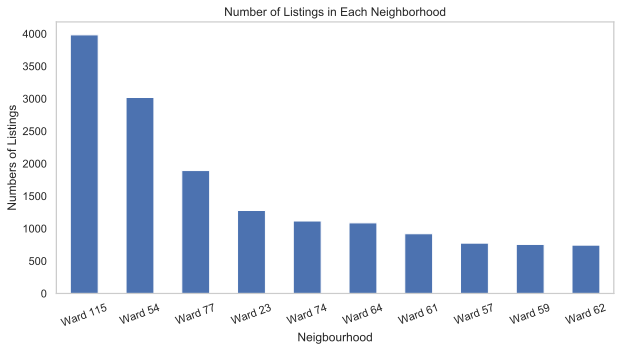

In [5]:
plt.figure(figsize=(10,5))
cp_num_listings = airbnb_capetown_raw.groupby('neighbourhood_cleansed')['room_type'].count().sort_values(ascending=False)
cp_num_listings_viz = cp_num_listings[:10].plot(kind = 'bar', title = 'Number of Listings in Each Neighborhood')
cp_num_listings_viz.set_xlabel('Neigbourhood')
cp_num_listings_viz.set_ylabel('Numbers of Listings')
cp_num_listings_viz.grid(False)
plt.xticks(rotation=20)
plt.show()

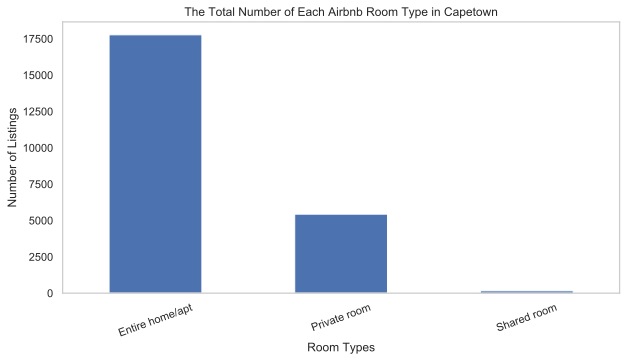

In [6]:
plt.figure(figsize=(10,5))
cp_room_type = airbnb_capetown_raw.groupby('room_type')['listing_url'].count().sort_values(ascending=False)
cp_room_type_viz = cp_room_type.plot(kind='bar', title = 'The Total Number of Each Airbnb Room Type in Capetown')
cp_room_type_viz.set_xlabel('Room Types')
cp_room_type_viz.set_ylabel('Number of Listings')
cp_room_type_viz.grid(False)
plt.xticks(rotation=20)
plt.show()

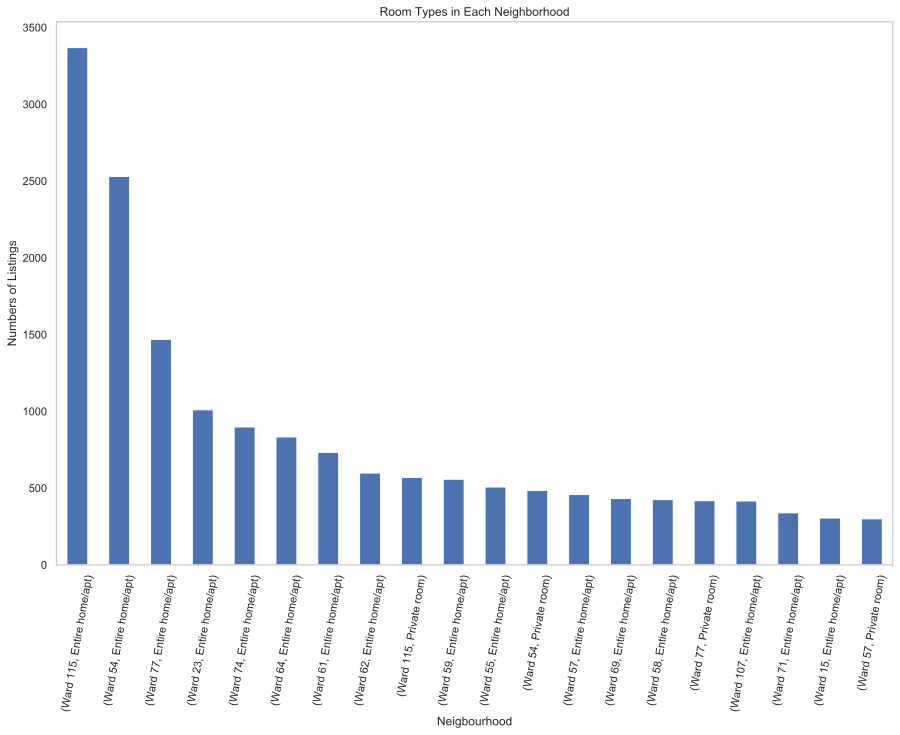

In [7]:
plt.figure(figsize=(15,10))
cp_room_type = airbnb_capetown_raw.groupby(['neighbourhood_cleansed', 'room_type'])['room_type'].count().sort_values(ascending=False)
cp_room_type_viz = cp_room_type[:20].plot(kind = 'bar', title = 'Room Types in Each Neighborhood')
cp_room_type_viz.set_xlabel('Neigbourhood')
cp_room_type_viz.set_ylabel('Numbers of Listings')
cp_room_type_viz.grid(False)
plt.xticks(rotation=80)
plt.show()

In [8]:
cp_host_since = airbnb_capetown_raw[['host_since', 'neighbourhood_cleansed', 'room_type']]

In [9]:
cp_host_since['host_since_datetime'] = pd.to_datetime(cp_host_since['host_since'])

In [10]:
cp_host_since = cp_host_since.dropna()

In [11]:
cp_host_since['since_year'] = cp_host_since['host_since_datetime'].apply(lambda x: x.year)
cp_host_since['since_month'] = cp_host_since['host_since_datetime'].apply(lambda x: x.month)
cp_host_since['since_day'] = cp_host_since['host_since_datetime'].apply(lambda x: x.day)

In [12]:
cp_host_since.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23341 entries, 0 to 23367
Data columns (total 7 columns):
host_since                23341 non-null object
neighbourhood_cleansed    23341 non-null object
room_type                 23341 non-null object
host_since_datetime       23341 non-null datetime64[ns]
since_year                23341 non-null int64
since_month               23341 non-null int64
since_day                 23341 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1.4+ MB


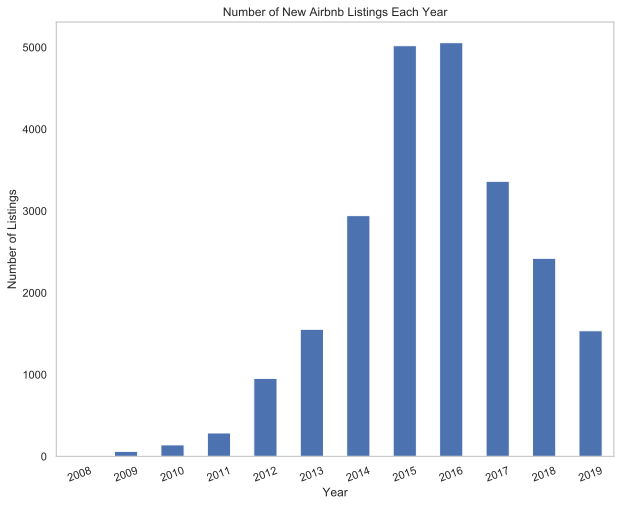

In [13]:
plt.figure(figsize=(10,8))
cp_host_since_year = cp_host_since.groupby('since_year')['since_year'].count()
cp_host_since_year_viz = cp_host_since_year[:20].plot(kind='bar', title = 'Number of New Airbnb Listings Each Year')
cp_host_since_year_viz.set_xlabel('Year')
cp_host_since_year_viz.set_ylabel('Number of Listings')
cp_host_since_year_viz.grid(False)
plt.xticks(rotation=20)
plt.show()

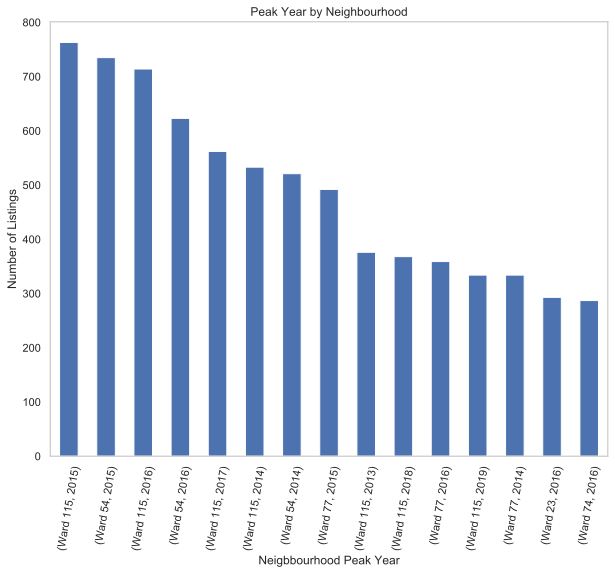

In [14]:
plt.figure(figsize=(10,8))
cp_host_peak_year_by_neigh = cp_host_since.groupby(['neighbourhood_cleansed', 'since_year'])['since_year'].count().sort_values(ascending=False)
cp_host_peak_year_by_neigh_viz = cp_host_peak_year_by_neigh[:15].plot(kind='bar', title = 'Peak Year by Neighbourhood')
cp_host_peak_year_by_neigh_viz.set_xlabel('Neigbbourhood Peak Year')
cp_host_peak_year_by_neigh_viz.set_ylabel('Number of Listings')
plt.grid(False)
plt.xticks(rotation=80)
plt.show()

In [15]:
#convert price to float integer
cp_host_avg_price_df = airbnb_capetown_raw[['neighbourhood_cleansed', 'price']]
cp_host_avg_price_df['price'] = cp_host_avg_price_df['price'].replace('[\$,]', '', regex=True).astype(float)

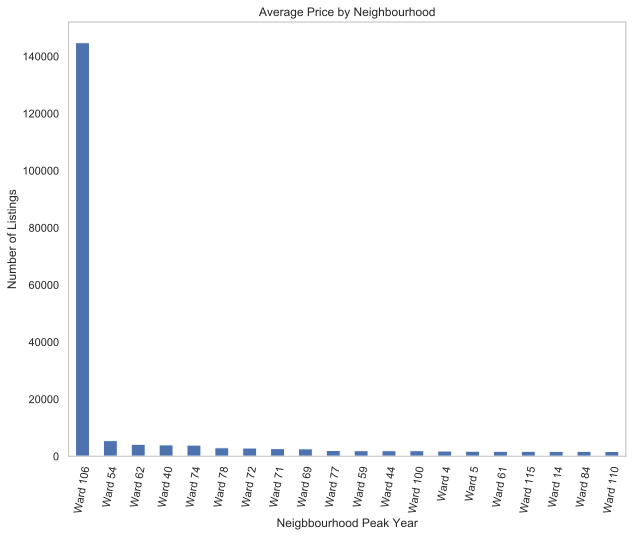

In [16]:
plt.figure(figsize=(10,8))
cp_host_avg_price = cp_host_avg_price_df.groupby(['neighbourhood_cleansed'])\
                    ['price'].mean().sort_values(ascending=False)
cp_host_avg_price_viz = cp_host_avg_price[:20].plot(kind='bar', title = 'Average Price by Neighbourhood')
cp_host_avg_price_viz.set_xlabel('Neigbbourhood Peak Year')
cp_host_avg_price_viz.set_ylabel('Number of Listings')
plt.grid(False)
plt.xticks(rotation=80)
plt.show()

### Outlier?
Looks like we got an outlier. Let's check on neighbourhood ward 106.

In [17]:
cp_host_avg_price_df[cp_host_avg_price_df['neighbourhood_cleansed'] == 'Ward 106']

,neighbourhood_cleansed,price
21965,Ward 106,144791.0


Drop this row and make graph again

In [18]:
cp_host_avg_price_df = cp_host_avg_price_df[cp_host_avg_price_df['neighbourhood_cleansed'] != 'Ward 106']

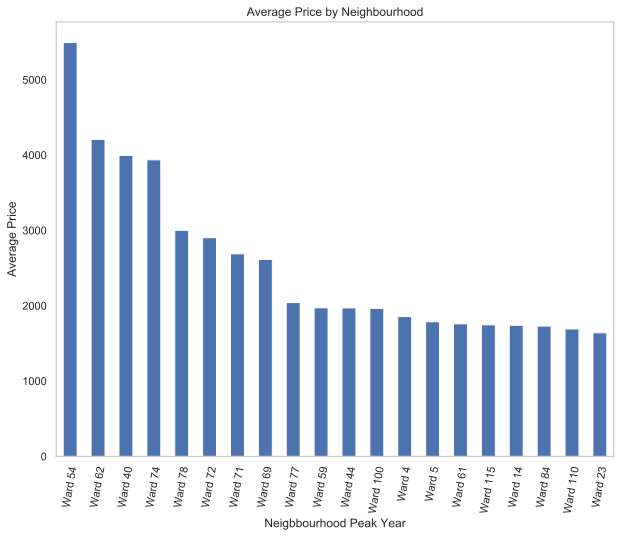

In [19]:
plt.figure(figsize=(10,8))
cp_host_avg_price = cp_host_avg_price_df.groupby(['neighbourhood_cleansed'])\
                    ['price'].mean().sort_values(ascending=False)
cp_host_avg_price_viz = cp_host_avg_price[:20].plot(kind='bar', title = 'Average Price by Neighbourhood')
cp_host_avg_price_viz.set_xlabel('Neigbbourhood Peak Year')
cp_host_avg_price_viz.set_ylabel('Average Price')
plt.grid(False)
plt.xticks(rotation=80)
plt.show()

Looks much better without extreme value.

## Develop features for predictive model

In [296]:
#will include review scores in future analysis
airbnb_cp_df = airbnb_capetown_raw[['id', 'listing_url', 'name', 'neighbourhood_cleansed', 'room_type',\
                                    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',\
                                    'minimum_nights', 'availability_30', 'availability_60', 'availability_90',\
                                    'availability_365', 'number_of_reviews_ltm',
                                    #'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',\
                                    #'review_scores_communication', 'review_scores_location', 'review_scores_value',\
                                    'calculated_host_listings_count']]

In [297]:
airbnb_cp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23368 entries, 0 to 23367
Data columns (total 17 columns):
id                                23368 non-null int64
listing_url                       23368 non-null object
name                              23368 non-null object
neighbourhood_cleansed            23368 non-null object
room_type                         23368 non-null object
accommodates                      23368 non-null int64
bathrooms                         23348 non-null float64
bedrooms                          23359 non-null float64
beds                              23314 non-null float64
price                             23368 non-null object
minimum_nights                    23368 non-null int64
availability_30                   23368 non-null int64
availability_60                   23368 non-null int64
availability_90                   23368 non-null int64
availability_365                  23368 non-null int64
number_of_reviews_ltm             23368 non-null int64


In [298]:
#replace null value with 0 in bathrooms column, most of them are either dorms or shared rooms
#hence no individual bathroom
airbnb_cp_df['bathrooms'] = airbnb_cp_df['bathrooms'].fillna(0)

In [299]:
#replace null value with 1 in bedrooms column
airbnb_cp_df['bedrooms'] = airbnb_cp_df['bedrooms'].fillna(1)

In [300]:
#after examine on null values in beds column, there is no way to infer how many beds. therefore, drop null rows
airbnb_cp_df.dropna(inplace=True)

In [303]:
#convert price string into usable float format
airbnb_cp_df['price'] = airbnb_cp_df['price'].replace('[\$,]', '', regex=True).astype(float)

In [304]:
airbnb_cp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23314 entries, 0 to 23367
Data columns (total 17 columns):
id                                23314 non-null int64
listing_url                       23314 non-null object
name                              23314 non-null object
neighbourhood_cleansed            23314 non-null object
room_type                         23314 non-null object
accommodates                      23314 non-null int64
bathrooms                         23314 non-null float64
bedrooms                          23314 non-null float64
beds                              23314 non-null float64
price                             23314 non-null float64
minimum_nights                    23314 non-null int64
availability_30                   23314 non-null int64
availability_60                   23314 non-null int64
availability_90                   23314 non-null int64
availability_365                  23314 non-null int64
number_of_reviews_ltm             23314 non-null int64

In [305]:
airbnb_cp_df.head()

,id,listing_url,name,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,calculated_host_listings_count
0,3191,https://www.airbnb.com/rooms/3191,Malleson Garden Cottage,Ward 57,Entire home/apt,2,1.0,1.0,1.0,720.0,3,16,44,74,332,8,1
1,13044,https://www.airbnb.com/rooms/13044,JAMBO Guest House / Green Room,Ward 115,Private room,2,1.0,1.0,1.0,1102.0,3,0,0,0,0,0,5
2,15007,https://www.airbnb.com/rooms/15007,Blaauwberg House,Ward 23,Entire home/apt,6,3.0,3.0,4.0,2036.0,2,30,60,82,336,5,2
3,15068,https://www.airbnb.com/rooms/15068,Grande Bay,Ward 23,Entire home/apt,6,2.0,3.0,5.0,2802.0,4,30,60,90,365,0,14
4,15077,https://www.airbnb.com/rooms/15077,Top relaxed beach living in style,Ward 4,Private room,2,1.5,1.0,2.0,1439.0,6,29,59,89,364,0,5


## Natural Language Processing

In [139]:
cp_reviews_raw = pd.read_csv('../airbnb_capetown/reviews.csv.gz')

In [21]:
cp_reviews_raw = cp_reviews_raw.dropna()

In [22]:
cp_reviews_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283903 entries, 0 to 284010
Data columns (total 6 columns):
listing_id       283903 non-null int64
id               283903 non-null int64
date             283903 non-null object
reviewer_id      283903 non-null int64
reviewer_name    283903 non-null object
comments         283903 non-null object
dtypes: int64(3), object(3)
memory usage: 15.2+ MB


In [250]:
cp_reviews_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...


### Topic Modeling & LDA

In [130]:
import string

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import *
from nltk import PorterStemmer

#LDA and other modeling
from sklearn.feature_extraction.text import CountVectorizer

import pprint

np.random.seed(2018)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Sitang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [144]:
comments = cp_reviews_raw[['comments']]

In [24]:
#set up stopwords
stopwords=set(stopwords.words('english'))

In [25]:
print(stopwords)

{'its', 'against', 'his', 'hasn', 'most', 'out', 'needn', 'did', 'why', 'yourselves', 'have', 'so', 'am', 'm', 'with', 'more', 'itself', 'then', 'do', 'because', 'or', 'i', 'between', 'mustn', 'won', 'ain', 'o', 'hadn', 'once', 'didn', 'but', 'should', 'whom', 'myself', 'my', 'll', 'isn', 'couldn', 'were', 'having', 'ourselves', 'again', 'haven', 'there', 'yourself', 'own', 'from', 'here', 'during', 'y', 'themselves', 'shouldn', 'just', 'not', 'him', 'you', 'of', 'been', 'while', 'over', 'is', 'a', 'at', 'before', 'he', 'all', 'ma', 'if', 'theirs', 'them', 'weren', 'was', 'had', 't', 'does', 'no', 'in', 'the', 'both', 'same', 'she', 'into', 'doing', 'through', 'below', 'and', 'now', 'our', 'ours', 'as', 've', 'for', 'wouldn', 'above', 'are', 'off', 'this', 'yours', 'your', 'further', 'other', 'than', 'be', 'when', 'too', 'we', 're', 'which', 'who', 'only', 'hers', 'until', 'what', 'some', 'himself', 'doesn', 'can', 'aren', 'wasn', 'will', 'under', 'has', 'd', 'few', 'where', 'any', 'mi

In [26]:
#extract comments from airbnb reviews dataframe
reviews = cp_reviews_raw[['comments']]

In [27]:
reviews.head()

,comments
0,Great home away from home! Bridgette and Marth...
1,Das Cottage liegt ruhig und sicher. Wir haben...
2,This cottage was a great base from which to ex...
3,I had a great stay. All my needs were well ex...
4,Excellent host. She provided everything we cou...


In [29]:
reviews.comments[0]

'Great home away from home! Bridgette and Martha were wonderful! I would recommend this place for couples, friends or family! '

In [30]:
#split comments
#test_sentences = []

#test_sentences = test_sentences.append(x for x in test_comment)

#decompose lists into a single list
#test_sentences = [item for sublist in test_sentences for item in sublist]

In [31]:
#remove punctuations for test_sentences
remove_punct = str.maketrans('', '', string.punctuation)
reviews_sentences = [c.translate(remove_punct) for c in reviews.comments]

In [32]:
reviews_sentences[:5]

['Great home away from home Bridgette and Martha were wonderful I would recommend this place for couples friends or family ',
 'Das Cottage liegt ruhig und sicher  Wir haben alles gefunden was wir benötigten Mit dem Auto ist man in gut zehn Minuten in der City oder Waterfront  Der Empfang durch Brigitte  war sehr nett und sie hatte schon Wein und einige Kleinigkeiten zum Essen besorgt',
 'This cottage was a great base from which to explore the amazing city of Cape Town Its well equipped so I felt right at home Brigitte was an attentive organised host and helped make my stay memorable',
 'I had a great stay  All my needs were well exceeded with warmhearted hospitality  Would definitely stay here again',
 'Excellent host She provided everything we could think of during our stay  The cottage is lovely and clean and very tranquil I would definitely stay here again ']

In [33]:
#convert to lowercase
reviews_sentences = [s.lower() for s in reviews_sentences]

In [85]:
reviews_sentences[:2]

['great home away from home bridgette and martha were wonderful i would recommend this place for couples friends or family ',
 'das cottage liegt ruhig und sicher  wir haben alles gefunden was wir benötigten mit dem auto ist man in gut zehn minuten in der city oder waterfront  der empfang durch brigitte  war sehr nett und sie hatte schon wein und einige kleinigkeiten zum essen besorgt']

### make a list of words in English only

In [86]:
split_sentences = [s.split() for s in reviews_sentences]

In [87]:
split_sentences = [s for sublist in split_sentences for s in sublist]

In [88]:
split_sentences[:5]

['great', 'home', 'away', 'from', 'home']

In [89]:
#remove non-alphabet characters
eng_words = set(nltk.corpus.words.words())
reviews_words = [s for s in split_sentences if s in eng_words or not s.isalpha()]

In [90]:
reviews_words[:5]

['great', 'home', 'away', 'from', 'home']

In [91]:
#remove stop words
reviews_words = [s for s in reviews_words if not s in stopwords]

In [92]:
print(reviews_words[:20])

['great', 'home', 'away', 'home', 'wonderful', 'would', 'recommend', 'place', 'family', 'das', 'cottage', 'wir', 'wir', 'auto', 'ist', 'man', 'gut', 'city', 'waterfront', 'war']


### to make a list of sentences only in english words
### if not able to do so, just remove stop words and tokenized

In [100]:
#tokenizer
def token_reviews(cp_reviews):
    for r in cp_reviews:
        yield(gensim.utils.simple_preprocess(str(r), deacc=True))  # deacc=True removes punctuation

In [101]:
tokens = list(token_reviews(reviews_sentences))

In [102]:
print(tokens[:2])

[['great', 'home', 'away', 'from', 'home', 'bridgette', 'and', 'martha', 'were', 'wonderful', 'would', 'recommend', 'this', 'place', 'for', 'couples', 'friends', 'or', 'family'], ['das', 'cottage', 'liegt', 'ruhig', 'und', 'sicher', 'wir', 'haben', 'alles', 'gefunden', 'was', 'wir', 'benotigten', 'mit', 'dem', 'auto', 'ist', 'man', 'in', 'gut', 'zehn', 'minuten', 'in', 'der', 'city', 'oder', 'waterfront', 'der', 'empfang', 'durch', 'brigitte', 'war', 'sehr', 'nett', 'und', 'sie', 'hatte', 'schon', 'wein', 'und', 'einige', 'kleinigkeiten', 'zum', 'essen', 'besorgt']]


In [103]:
cp_token_reviews = []
for t in tokens:
    tempt = []
    for w in t:
        if w not in stopwords:
            tempt.append(w)
        cp_token_reviews.append(tempt)
    
    

In [104]:
cp_token_reviews[:2]

[['great', 'home', 'away', 'home', 'bridgette', 'martha', 'wonderful', 'would', 'recommend', 'place', 'couples', 'friends', 'family'], ['great', 'home', 'away', 'home', 'bridgette', 'martha', 'wonderful', 'would', 'recommend', 'place', 'couples', 'friends', 'family']]

In [105]:
dictionary = corpora.Dictionary(cp_token_reviews)

In [106]:
corpus = [dictionary.doc2bow(cp_token) for cp_token in cp_token_reviews]

In [128]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=15, 
                                           random_state=1)

In [131]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(lda_model.print_topics())

[ ( 0,
    '0.152*"mountain" + 0.087*"water" + 0.085*"shower" + 0.069*"bit" + '
    '0.063*"sleep" + 0.041*"hot" + 0.039*"tips" + 0.034*"head" + 0.034*"met" + '
    '0.031*"cool"'),
  ( 1,
    '0.066*"und" + 0.047*"die" + 0.037*"ist" + 0.034*"fast" + 0.031*"der" + '
    '0.030*"sehr" + 0.025*"es" + 0.023*"wir" + 0.021*"bad" + 0.020*"war"'),
  ( 2,
    '0.067*"value" + 0.067*"good" + 0.065*"coffee" + 0.064*"room" + '
    '0.060*"money" + 0.053*"bathroom" + 0.044*"tv" + 0.041*"nice" + '
    '0.041*"morning" + 0.039*"bed"'),
  ( 3,
    '0.080*"first" + 0.075*"accommodation" + 0.050*"never" + 0.045*"quality" + '
    '0.043*"arrived" + 0.041*"though" + 0.035*"nothing" + 0.031*"thought" + '
    '0.030*"checked" + 0.029*"price"'),
  ( 4,
    '0.053*"great" + 0.050*"place" + 0.040*"stay" + 0.033*"location" + '
    '0.032*"town" + 0.030*"cape" + 0.024*"clean" + 0.022*"recommend" + '
    '0.019*"host" + 0.019*"would"'),
  ( 5,
    '0.033*"us" + 0.030*"stay" + 0.030*"place" + 0.024*"home" + '
   

In [122]:
count_vectorizer = CountVectorizer(stop_words='english')

In [123]:
count_data = count_vectorizer.fit_transform(reviews_sentences)

In [124]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [127]:
reviews_sentences[:10]

['great home away from home bridgette and martha were wonderful i would recommend this place for couples friends or family ', 'das cottage liegt ruhig und sicher  wir haben alles gefunden was wir benötigten mit dem auto ist man in gut zehn minuten in der city oder waterfront  der empfang durch brigitte  war sehr nett und sie hatte schon wein und einige kleinigkeiten zum essen besorgt', 'this cottage was a great base from which to explore the amazing city of cape town its well equipped so i felt right at home brigitte was an attentive organised host and helped make my stay memorable', 'i had a great stay  all my needs were well exceeded with warmhearted hospitality  would definitely stay here again', 'excellent host she provided everything we could think of during our stay  the cottage is lovely and clean and very tranquil i would definitely stay here again ', 'we kregen een verwarmend welkom in het huisje stond al koffie en the klaar ook was er meer dan voldoende folder materiaal voor 

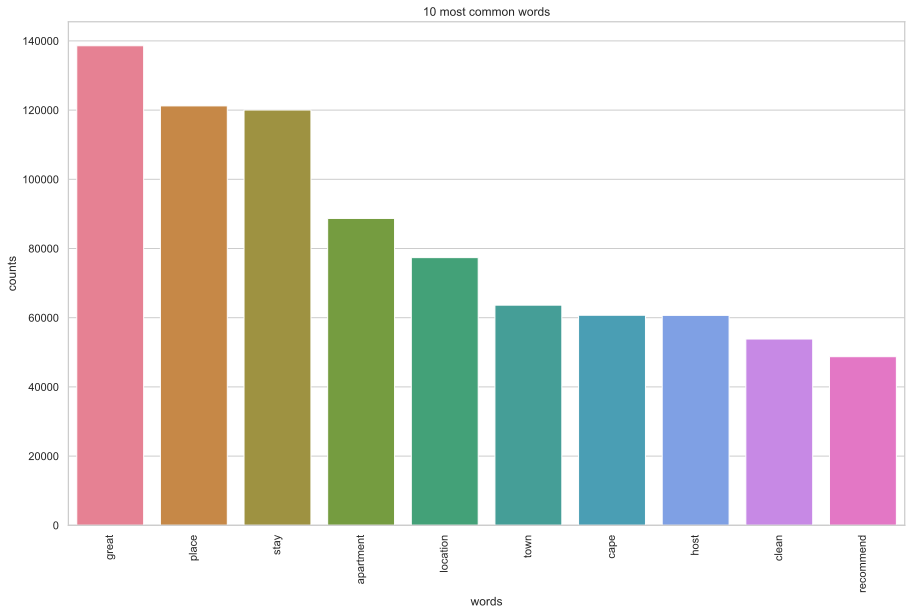

In [125]:
plot_10_most_common_words(count_data, count_vectorizer)

## Try to remove these not so meaningful words and will generate visualization again

In [133]:
print('hello, this is not working')

hello, this is not working


## Geo Visualization

In [21]:
capetown_geo = gpd.read_file('../neighbourhoods.geojson')

In [25]:
type(capetown_geo)

geopandas.geodataframe.GeoDataFrame

In [ ]:
capetown_data = airbnb_capetown_raw['id', 'listing_url', 'latitude', 'longitude', '']

In [62]:
m = folium.Map(location=[-33.93, 18.42], zoom_start=10, tiles='cartodbpositron')


In [82]:
#folium.TopoJson(
#    data=cp_num_listings_geometry,
#    'test'
#).add_to(m)

#folium.LayerControl().add_to(m)
#https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf